## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.70
    pseudo_threshold = 0.95
    ending_threshold = 50

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
            ending_threshold = 100

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") >= float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{n_epochs:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
        print(f"[Valid | {epoch + 1:03d}/{n_epochs:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        if epoch - best_epoch >= ending_threshold:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 2000

# Whether to do semi-supervised learning.
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 5.32658, acc = 0.08596
[Valid | 001/2000][Best | 1] loss = 3.63348[3.63348], acc = 0.09325[0.09325]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 2.56619, acc = 0.10018
[Valid | 002/2000][Best | 2] loss = 2.63338[2.63338], acc = 0.10913[0.10913]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 2.48296, acc = 0.09403
[Valid | 003/2000][Best | 2] loss = 2.41768[2.63338], acc = 0.09573[0.10913]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 2.46721, acc = 0.08808
[Valid | 004/2000][Best | 2] loss = 2.42751[2.63338], acc = 0.09524[0.10913]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 2.43608, acc = 0.08913
[Valid | 005/2000][Best | 2] loss = 2.40247[2.63338], acc = 0.10516[0.10913]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 2.43420, acc = 0.09327
[Valid | 006/2000][Best | 6] loss = 2.40436[2.40436], acc = 0.12103[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 2.41987, acc = 0.09690
[Valid | 007/2000][Best | 6] loss = 2.41688[2.40436], acc = 0.09524[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 2.41824, acc = 0.09024
[Valid | 008/2000][Best | 6] loss = 2.38817[2.40436], acc = 0.10169[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 2.40887, acc = 0.10064
[Valid | 009/2000][Best | 6] loss = 2.38844[2.40436], acc = 0.11310[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 2.41102, acc = 0.09615
[Valid | 010/2000][Best | 6] loss = 2.38682[2.40436], acc = 0.10714[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 2.40807, acc = 0.10699
[Valid | 011/2000][Best | 6] loss = 2.37351[2.40436], acc = 0.11905[0.12103]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 2.40739, acc = 0.09867
[Valid | 012/2000][Best | 12] loss = 2.38737[2.38737], acc = 0.12748[0.12748]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 2.40174, acc = 0.11289
[Valid | 013/2000][Best | 13] loss = 2.36482[2.36482], acc = 0.12946[0.12946]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 2.39367, acc = 0.11244
[Valid | 014/2000][Best | 14] loss = 2.35525[2.35525], acc = 0.14087[0.14087]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 2.39493, acc = 0.11602
[Valid | 015/2000][Best | 14] loss = 2.36295[2.35525], acc = 0.14583[0.14087]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 2.39197, acc = 0.12712
[Valid | 016/2000][Best | 16] loss = 2.34565[2.34565], acc = 0.14137[0.14137]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 2.39465, acc = 0.12212
[Valid | 017/2000][Best | 16] loss = 2.37043[2.34565], acc = 0.13889[0.14137]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 2.39460, acc = 0.11542
[Valid | 018/2000][Best | 16] loss = 2.35354[2.34565], acc = 0.11210[0.14137]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 2.39490, acc = 0.11209
[Valid | 019/2000][Best | 16] loss = 2.34741[2.34565], acc = 0.13343[0.14137]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 2.38069, acc = 0.11456
[Valid | 020/2000][Best | 20] loss = 2.34388[2.34388], acc = 0.14782[0.14782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 2.38741, acc = 0.11668
[Valid | 021/2000][Best | 20] loss = 2.37789[2.34388], acc = 0.12302[0.14782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 2.37950, acc = 0.11849
[Valid | 022/2000][Best | 20] loss = 2.38809[2.34388], acc = 0.10863[0.14782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 2.37269, acc = 0.12515
[Valid | 023/2000][Best | 23] loss = 2.32751[2.32751], acc = 0.15179[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 2.38593, acc = 0.12167
[Valid | 024/2000][Best | 23] loss = 2.30975[2.32751], acc = 0.12996[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 2.37653, acc = 0.12707
[Valid | 025/2000][Best | 23] loss = 2.34954[2.32751], acc = 0.13641[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 2.36600, acc = 0.13035
[Valid | 026/2000][Best | 23] loss = 2.31329[2.32751], acc = 0.15129[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 2.37062, acc = 0.12782
[Valid | 027/2000][Best | 23] loss = 2.32765[2.32751], acc = 0.15575[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 2.37016, acc = 0.13574
[Valid | 028/2000][Best | 23] loss = 2.33885[2.32751], acc = 0.13938[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 2.37607, acc = 0.12086
[Valid | 029/2000][Best | 23] loss = 2.36989[2.32751], acc = 0.11359[0.15179]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 2.36840, acc = 0.12974
[Valid | 030/2000][Best | 30] loss = 2.32004[2.32004], acc = 0.16121[0.16121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 2.36550, acc = 0.11925
[Valid | 031/2000][Best | 30] loss = 2.32917[2.32004], acc = 0.12897[0.16121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 2.36576, acc = 0.12666
[Valid | 032/2000][Best | 30] loss = 2.32257[2.32004], acc = 0.14732[0.16121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 2.36003, acc = 0.12914
[Valid | 033/2000][Best | 33] loss = 2.29614[2.29614], acc = 0.16617[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 2.35706, acc = 0.11970
[Valid | 034/2000][Best | 33] loss = 2.31886[2.29614], acc = 0.15228[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 2.35832, acc = 0.12530
[Valid | 035/2000][Best | 33] loss = 2.28060[2.29614], acc = 0.14236[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 2.35813, acc = 0.11940
[Valid | 036/2000][Best | 33] loss = 2.37882[2.29614], acc = 0.12798[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 2.35788, acc = 0.13771
[Valid | 037/2000][Best | 33] loss = 2.29889[2.29614], acc = 0.13442[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 2.36954, acc = 0.12207
[Valid | 038/2000][Best | 33] loss = 2.29472[2.29614], acc = 0.15526[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 2.35908, acc = 0.13060
[Valid | 039/2000][Best | 33] loss = 2.32133[2.29614], acc = 0.14831[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 2.36042, acc = 0.12334
[Valid | 040/2000][Best | 33] loss = 2.31269[2.29614], acc = 0.16022[0.16617]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 2.35433, acc = 0.13474
[Valid | 041/2000][Best | 41] loss = 2.29050[2.29050], acc = 0.17113[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 2.35602, acc = 0.13443
[Valid | 042/2000][Best | 41] loss = 2.33067[2.29050], acc = 0.16617[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 2.35532, acc = 0.12555
[Valid | 043/2000][Best | 41] loss = 2.28502[2.29050], acc = 0.15625[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 2.33751, acc = 0.13262
[Valid | 044/2000][Best | 41] loss = 2.28579[2.29050], acc = 0.16022[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 2.34034, acc = 0.12409
[Valid | 045/2000][Best | 41] loss = 2.40177[2.29050], acc = 0.12599[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 2.34574, acc = 0.13257
[Valid | 046/2000][Best | 41] loss = 2.30653[2.29050], acc = 0.14931[0.17113]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 2.33373, acc = 0.14049
[Valid | 047/2000][Best | 47] loss = 2.24857[2.24857], acc = 0.18254[0.18254]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 2.35783, acc = 0.12969
[Valid | 048/2000][Best | 47] loss = 2.28164[2.24857], acc = 0.16667[0.18254]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 2.32883, acc = 0.14714
[Valid | 049/2000][Best | 47] loss = 2.35654[2.24857], acc = 0.12351[0.18254]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 2.33418, acc = 0.14624
[Valid | 050/2000][Best | 47] loss = 2.28415[2.24857], acc = 0.14187[0.18254]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 2.31504, acc = 0.14427
[Valid | 051/2000][Best | 47] loss = 2.23651[2.24857], acc = 0.17063[0.18254]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 2.30789, acc = 0.14513
[Valid | 052/2000][Best | 52] loss = 2.21875[2.21875], acc = 0.18552[0.18552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 2.31297, acc = 0.14250
[Valid | 053/2000][Best | 52] loss = 2.39938[2.21875], acc = 0.10218[0.18552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 2.31367, acc = 0.15885
[Valid | 054/2000][Best | 52] loss = 2.22902[2.21875], acc = 0.16319[0.18552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 2.29843, acc = 0.15451
[Valid | 055/2000][Best | 52] loss = 2.23009[2.21875], acc = 0.18056[0.18552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 2.27591, acc = 0.15421
[Valid | 056/2000][Best | 52] loss = 2.28225[2.21875], acc = 0.16319[0.18552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 2.26967, acc = 0.17217
[Valid | 057/2000][Best | 57] loss = 2.21123[2.21123], acc = 0.18750[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 2.28122, acc = 0.15592
[Valid | 058/2000][Best | 57] loss = 2.22431[2.21123], acc = 0.20437[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 2.26283, acc = 0.16167
[Valid | 059/2000][Best | 57] loss = 2.37416[2.21123], acc = 0.14484[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 2.25887, acc = 0.17196
[Valid | 060/2000][Best | 57] loss = 2.21526[2.21123], acc = 0.17857[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 2.25260, acc = 0.17398
[Valid | 061/2000][Best | 57] loss = 2.25391[2.21123], acc = 0.17659[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 2.26067, acc = 0.17504
[Valid | 062/2000][Best | 57] loss = 2.23478[2.21123], acc = 0.17212[0.18750]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 2.25394, acc = 0.17106
[Valid | 063/2000][Best | 63] loss = 2.17786[2.17786], acc = 0.18899[0.18899]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 2.24417, acc = 0.18604
[Valid | 064/2000][Best | 64] loss = 2.15145[2.15145], acc = 0.21577[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 2.22427, acc = 0.18624
[Valid | 065/2000][Best | 64] loss = 2.19048[2.15145], acc = 0.17510[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 2.24163, acc = 0.18679
[Valid | 066/2000][Best | 64] loss = 2.17815[2.15145], acc = 0.21280[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 2.21919, acc = 0.18634
[Valid | 067/2000][Best | 64] loss = 2.16332[2.15145], acc = 0.19544[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 2.22032, acc = 0.18357
[Valid | 068/2000][Best | 64] loss = 2.15579[2.15145], acc = 0.20982[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 2.22878, acc = 0.18362
[Valid | 069/2000][Best | 64] loss = 2.16367[2.15145], acc = 0.20387[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 2.19759, acc = 0.21116
[Valid | 070/2000][Best | 64] loss = 2.16649[2.15145], acc = 0.20288[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 2.22256, acc = 0.18311
[Valid | 071/2000][Best | 64] loss = 2.20829[2.15145], acc = 0.19296[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 2.22101, acc = 0.19098
[Valid | 072/2000][Best | 64] loss = 2.16144[2.15145], acc = 0.20288[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 2.22179, acc = 0.18760
[Valid | 073/2000][Best | 64] loss = 2.21409[2.15145], acc = 0.17708[0.21577]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 2.20049, acc = 0.19779
[Valid | 074/2000][Best | 74] loss = 2.14552[2.14552], acc = 0.22371[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 2.19426, acc = 0.20778
[Valid | 075/2000][Best | 74] loss = 2.12394[2.14552], acc = 0.20734[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 2.21302, acc = 0.20364
[Valid | 076/2000][Best | 74] loss = 2.16446[2.14552], acc = 0.18948[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 2.20159, acc = 0.20183
[Valid | 077/2000][Best | 74] loss = 2.15299[2.14552], acc = 0.20337[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 2.20646, acc = 0.19320
[Valid | 078/2000][Best | 74] loss = 2.19504[2.14552], acc = 0.19940[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 2.18967, acc = 0.19592
[Valid | 079/2000][Best | 74] loss = 2.16579[2.14552], acc = 0.20784[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 2.20623, acc = 0.19628
[Valid | 080/2000][Best | 74] loss = 2.16458[2.14552], acc = 0.23065[0.22371]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 2.17909, acc = 0.19920
[Valid | 081/2000][Best | 81] loss = 2.10427[2.10427], acc = 0.25248[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 2.17526, acc = 0.21050
[Valid | 082/2000][Best | 81] loss = 2.15996[2.10427], acc = 0.22073[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 2.18584, acc = 0.21903
[Valid | 083/2000][Best | 81] loss = 2.13010[2.10427], acc = 0.23016[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 2.18804, acc = 0.20072
[Valid | 084/2000][Best | 81] loss = 2.29667[2.10427], acc = 0.19196[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 2.18959, acc = 0.20480
[Valid | 085/2000][Best | 81] loss = 2.16674[2.10427], acc = 0.19444[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 2.18441, acc = 0.20818
[Valid | 086/2000][Best | 81] loss = 2.09960[2.10427], acc = 0.22173[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 2.17433, acc = 0.21454
[Valid | 087/2000][Best | 81] loss = 2.14497[2.10427], acc = 0.20387[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 2.17983, acc = 0.20864
[Valid | 088/2000][Best | 81] loss = 2.11419[2.10427], acc = 0.25099[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 2.17750, acc = 0.21116
[Valid | 089/2000][Best | 81] loss = 2.14633[2.10427], acc = 0.21032[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 2.15180, acc = 0.21555
[Valid | 090/2000][Best | 81] loss = 2.18534[2.10427], acc = 0.21776[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 2.15979, acc = 0.20959
[Valid | 091/2000][Best | 81] loss = 2.18397[2.10427], acc = 0.19494[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 2.16900, acc = 0.21610
[Valid | 092/2000][Best | 81] loss = 2.09539[2.10427], acc = 0.24752[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 2.16143, acc = 0.21474
[Valid | 093/2000][Best | 81] loss = 2.07017[2.10427], acc = 0.24950[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 2.16078, acc = 0.22261
[Valid | 094/2000][Best | 81] loss = 2.15711[2.10427], acc = 0.21776[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 2.15531, acc = 0.21171
[Valid | 095/2000][Best | 81] loss = 2.06604[2.10427], acc = 0.24603[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 2.15046, acc = 0.21696
[Valid | 096/2000][Best | 81] loss = 2.18453[2.10427], acc = 0.20387[0.25248]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 2.14876, acc = 0.23018
[Valid | 097/2000][Best | 97] loss = 2.06965[2.06965], acc = 0.26438[0.26438]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 2.15685, acc = 0.21973
[Valid | 098/2000][Best | 97] loss = 2.03063[2.06965], acc = 0.25992[0.26438]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 2.13939, acc = 0.22992
[Valid | 099/2000][Best | 97] loss = 2.15705[2.06965], acc = 0.26438[0.26438]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 2.15010, acc = 0.23103
[Valid | 100/2000][Best | 100] loss = 2.04801[2.04801], acc = 0.27530[0.27530]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 2.14266, acc = 0.23537
[Valid | 101/2000][Best | 101] loss = 1.99522[1.99522], acc = 0.28819[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 2.12601, acc = 0.21827
[Valid | 102/2000][Best | 101] loss = 2.07069[1.99522], acc = 0.24355[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 2.14056, acc = 0.23224
[Valid | 103/2000][Best | 101] loss = 2.16894[1.99522], acc = 0.22718[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 2.13614, acc = 0.22695
[Valid | 104/2000][Best | 101] loss = 2.01537[1.99522], acc = 0.26736[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 2.13326, acc = 0.21913
[Valid | 105/2000][Best | 101] loss = 2.20316[1.99522], acc = 0.22123[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 2.11180, acc = 0.25393
[Valid | 106/2000][Best | 101] loss = 2.00798[1.99522], acc = 0.28919[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 2.12508, acc = 0.23467
[Valid | 107/2000][Best | 101] loss = 2.05987[1.99522], acc = 0.25446[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 2.11722, acc = 0.24314
[Valid | 108/2000][Best | 101] loss = 2.26370[1.99522], acc = 0.20089[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 2.10085, acc = 0.24420
[Valid | 109/2000][Best | 101] loss = 2.06833[1.99522], acc = 0.27778[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 2.10255, acc = 0.24622
[Valid | 110/2000][Best | 101] loss = 2.03790[1.99522], acc = 0.28770[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 2.11052, acc = 0.25055
[Valid | 111/2000][Best | 101] loss = 2.10262[1.99522], acc = 0.25397[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 2.09808, acc = 0.24874
[Valid | 112/2000][Best | 101] loss = 2.02504[1.99522], acc = 0.27976[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 2.12841, acc = 0.24627
[Valid | 113/2000][Best | 101] loss = 1.98635[1.99522], acc = 0.27083[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 2.11666, acc = 0.24748
[Valid | 114/2000][Best | 101] loss = 2.02783[1.99522], acc = 0.28125[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 2.09280, acc = 0.25081
[Valid | 115/2000][Best | 101] loss = 2.02845[1.99522], acc = 0.28423[0.28819]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 2.10615, acc = 0.25091
[Valid | 116/2000][Best | 116] loss = 1.98098[1.98098], acc = 0.29415[0.29415]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 2.08261, acc = 0.25913
[Valid | 117/2000][Best | 116] loss = 2.01973[1.98098], acc = 0.27133[0.29415]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 2.08684, acc = 0.26196
[Valid | 118/2000][Best | 116] loss = 2.02211[1.98098], acc = 0.28075[0.29415]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 2.06027, acc = 0.27320
[Valid | 119/2000][Best | 119] loss = 1.93636[1.93636], acc = 0.31052[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 2.07644, acc = 0.26392
[Valid | 120/2000][Best | 119] loss = 1.95565[1.93636], acc = 0.31498[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 2.05667, acc = 0.26226
[Valid | 121/2000][Best | 119] loss = 2.03680[1.93636], acc = 0.27778[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 2.06766, acc = 0.26296
[Valid | 122/2000][Best | 119] loss = 1.95941[1.93636], acc = 0.30010[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 2.07091, acc = 0.25948
[Valid | 123/2000][Best | 119] loss = 1.99424[1.93636], acc = 0.29911[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 2.05384, acc = 0.25858
[Valid | 124/2000][Best | 119] loss = 1.92994[1.93636], acc = 0.30952[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 2.07530, acc = 0.26533
[Valid | 125/2000][Best | 119] loss = 1.98815[1.93636], acc = 0.28819[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 2.07189, acc = 0.26871
[Valid | 126/2000][Best | 119] loss = 1.97029[1.93636], acc = 0.28175[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 2.07917, acc = 0.25883
[Valid | 127/2000][Best | 119] loss = 2.01347[1.93636], acc = 0.27679[0.31052]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 2.04828, acc = 0.26987
[Valid | 128/2000][Best | 128] loss = 1.92135[1.92135], acc = 0.33284[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 2.04334, acc = 0.27951
[Valid | 129/2000][Best | 128] loss = 2.10209[1.92135], acc = 0.25298[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 2.06835, acc = 0.26806
[Valid | 130/2000][Best | 128] loss = 1.94244[1.92135], acc = 0.30605[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 2.05682, acc = 0.27527
[Valid | 131/2000][Best | 128] loss = 2.07765[1.92135], acc = 0.24405[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 2.05485, acc = 0.28511
[Valid | 132/2000][Best | 128] loss = 1.92963[1.92135], acc = 0.30258[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 2.05918, acc = 0.26423
[Valid | 133/2000][Best | 128] loss = 1.93076[1.92135], acc = 0.29563[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 2.04415, acc = 0.27840
[Valid | 134/2000][Best | 128] loss = 1.99709[1.92135], acc = 0.30407[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 2.05787, acc = 0.26614
[Valid | 135/2000][Best | 128] loss = 2.00819[1.92135], acc = 0.27629[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 2.04212, acc = 0.26871
[Valid | 136/2000][Best | 128] loss = 1.96557[1.92135], acc = 0.30407[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 2.04449, acc = 0.27431
[Valid | 137/2000][Best | 128] loss = 1.92764[1.92135], acc = 0.32192[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 2.02607, acc = 0.28012
[Valid | 138/2000][Best | 128] loss = 1.97894[1.92135], acc = 0.30456[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 2.05142, acc = 0.28017
[Valid | 139/2000][Best | 128] loss = 1.94591[1.92135], acc = 0.29812[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 2.02505, acc = 0.28385
[Valid | 140/2000][Best | 128] loss = 1.95503[1.92135], acc = 0.29613[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 2.00428, acc = 0.28975
[Valid | 141/2000][Best | 128] loss = 1.86989[1.92135], acc = 0.33085[0.33284]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 2.03018, acc = 0.27129
[Valid | 142/2000][Best | 142] loss = 1.86182[1.86182], acc = 0.34127[0.34127]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 2.01869, acc = 0.29202
[Valid | 143/2000][Best | 142] loss = 2.02096[1.86182], acc = 0.27877[0.34127]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 2.01779, acc = 0.27542
[Valid | 144/2000][Best | 142] loss = 1.90332[1.86182], acc = 0.32440[0.34127]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 1.99497, acc = 0.28919
[Valid | 145/2000][Best | 142] loss = 1.90581[1.86182], acc = 0.31250[0.34127]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 2.00430, acc = 0.29242
[Valid | 146/2000][Best | 146] loss = 1.85941[1.85941], acc = 0.35268[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/2000] loss = 2.01008, acc = 0.30448
[Valid | 147/2000][Best | 146] loss = 1.93828[1.85941], acc = 0.31895[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 2.00024, acc = 0.29767
[Valid | 148/2000][Best | 146] loss = 1.87396[1.85941], acc = 0.37202[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 1.99135, acc = 0.30524
[Valid | 149/2000][Best | 146] loss = 2.00883[1.85941], acc = 0.28274[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 2.01429, acc = 0.29464
[Valid | 150/2000][Best | 146] loss = 1.91062[1.85941], acc = 0.34772[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 2.01060, acc = 0.28415
[Valid | 151/2000][Best | 146] loss = 1.87066[1.85941], acc = 0.35516[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 2.01543, acc = 0.28138
[Valid | 152/2000][Best | 146] loss = 1.88645[1.85941], acc = 0.33383[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 1.99214, acc = 0.30524
[Valid | 153/2000][Best | 153] loss = 1.82408[1.82408], acc = 0.35268[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 1.96335, acc = 0.30857
[Valid | 154/2000][Best | 153] loss = 1.84329[1.82408], acc = 0.34077[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 1.97284, acc = 0.31749
[Valid | 155/2000][Best | 153] loss = 1.85250[1.82408], acc = 0.32540[0.35268]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 1.96875, acc = 0.30539
[Valid | 156/2000][Best | 156] loss = 1.80509[1.80509], acc = 0.37698[0.37698]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 1.97624, acc = 0.31144
[Valid | 157/2000][Best | 156] loss = 1.87677[1.80509], acc = 0.33780[0.37698]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 1.96828, acc = 0.30675
[Valid | 158/2000][Best | 156] loss = 1.86083[1.80509], acc = 0.34425[0.37698]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 1.96257, acc = 0.31265
[Valid | 159/2000][Best | 156] loss = 1.96565[1.80509], acc = 0.33234[0.37698]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 1.94403, acc = 0.31931
[Valid | 160/2000][Best | 160] loss = 1.79538[1.79538], acc = 0.39236[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 1.97680, acc = 0.31482
[Valid | 161/2000][Best | 160] loss = 1.80895[1.79538], acc = 0.38244[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 1.93997, acc = 0.32103
[Valid | 162/2000][Best | 160] loss = 1.82744[1.79538], acc = 0.36260[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 1.93606, acc = 0.33177
[Valid | 163/2000][Best | 160] loss = 1.88724[1.79538], acc = 0.35417[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 1.93151, acc = 0.32844
[Valid | 164/2000][Best | 160] loss = 1.83964[1.79538], acc = 0.35913[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 1.93914, acc = 0.32900
[Valid | 165/2000][Best | 160] loss = 1.85528[1.79538], acc = 0.34127[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 1.92659, acc = 0.32244
[Valid | 166/2000][Best | 160] loss = 1.82261[1.79538], acc = 0.35764[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 1.93168, acc = 0.32985
[Valid | 167/2000][Best | 160] loss = 1.80943[1.79538], acc = 0.38194[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 1.93304, acc = 0.32567
[Valid | 168/2000][Best | 160] loss = 1.85067[1.79538], acc = 0.34226[0.39236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 1.94403, acc = 0.32365
[Valid | 169/2000][Best | 169] loss = 1.77695[1.77695], acc = 0.39435[0.39435]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 1.91594, acc = 0.34080
[Valid | 170/2000][Best | 169] loss = 1.82950[1.77695], acc = 0.36210[0.39435]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 1.93788, acc = 0.33071
[Valid | 171/2000][Best | 171] loss = 1.75627[1.75627], acc = 0.39782[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 1.91693, acc = 0.33999
[Valid | 172/2000][Best | 171] loss = 1.77338[1.75627], acc = 0.39583[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/2000] loss = 1.89580, acc = 0.34559
[Valid | 173/2000][Best | 171] loss = 1.77845[1.75627], acc = 0.36458[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/2000] loss = 1.94025, acc = 0.32789
[Valid | 174/2000][Best | 171] loss = 1.76960[1.75627], acc = 0.39683[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/2000] loss = 1.88084, acc = 0.34786
[Valid | 175/2000][Best | 171] loss = 1.76256[1.75627], acc = 0.39931[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/2000] loss = 1.89695, acc = 0.33081
[Valid | 176/2000][Best | 171] loss = 1.89771[1.75627], acc = 0.34474[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/2000] loss = 1.89217, acc = 0.33934
[Valid | 177/2000][Best | 171] loss = 1.79822[1.75627], acc = 0.37599[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/2000] loss = 1.91656, acc = 0.33454
[Valid | 178/2000][Best | 171] loss = 1.73861[1.75627], acc = 0.38790[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/2000] loss = 1.90520, acc = 0.33974
[Valid | 179/2000][Best | 171] loss = 1.76444[1.75627], acc = 0.40327[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/2000] loss = 1.88984, acc = 0.34428
[Valid | 180/2000][Best | 171] loss = 1.77682[1.75627], acc = 0.37351[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/2000] loss = 1.91609, acc = 0.33364
[Valid | 181/2000][Best | 171] loss = 1.82919[1.75627], acc = 0.39286[0.39782]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/2000] loss = 1.88063, acc = 0.36113
[Valid | 182/2000][Best | 182] loss = 1.73774[1.73774], acc = 0.43105[0.43105]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/2000] loss = 1.87517, acc = 0.35623
[Valid | 183/2000][Best | 182] loss = 1.77226[1.73774], acc = 0.37202[0.43105]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/2000] loss = 1.88501, acc = 0.34050
[Valid | 184/2000][Best | 182] loss = 1.78401[1.73774], acc = 0.36409[0.43105]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/2000] loss = 1.86411, acc = 0.35467
[Valid | 185/2000][Best | 185] loss = 1.67113[1.67113], acc = 0.43502[0.43502]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/2000] loss = 1.89718, acc = 0.33333
[Valid | 186/2000][Best | 185] loss = 1.72110[1.67113], acc = 0.40972[0.43502]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/2000] loss = 1.88326, acc = 0.34453
[Valid | 187/2000][Best | 187] loss = 1.65916[1.65916], acc = 0.44246[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/2000] loss = 1.85785, acc = 0.36597
[Valid | 188/2000][Best | 187] loss = 1.73036[1.65916], acc = 0.40774[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/2000] loss = 1.86895, acc = 0.36037
[Valid | 189/2000][Best | 187] loss = 1.73301[1.65916], acc = 0.41319[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/2000] loss = 1.84793, acc = 0.37853
[Valid | 190/2000][Best | 187] loss = 1.77561[1.65916], acc = 0.35516[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/2000] loss = 1.82217, acc = 0.37878
[Valid | 191/2000][Best | 187] loss = 1.74684[1.65916], acc = 0.39881[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/2000] loss = 1.83210, acc = 0.37238
[Valid | 192/2000][Best | 187] loss = 1.75918[1.65916], acc = 0.41220[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/2000] loss = 1.84968, acc = 0.35694
[Valid | 193/2000][Best | 187] loss = 1.69877[1.65916], acc = 0.44643[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/2000] loss = 1.86639, acc = 0.36764
[Valid | 194/2000][Best | 187] loss = 1.67423[1.65916], acc = 0.42312[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/2000] loss = 1.85340, acc = 0.36380
[Valid | 195/2000][Best | 187] loss = 1.66463[1.65916], acc = 0.45040[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/2000] loss = 1.82894, acc = 0.37909
[Valid | 196/2000][Best | 187] loss = 1.70437[1.65916], acc = 0.43006[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/2000] loss = 1.79556, acc = 0.38080
[Valid | 197/2000][Best | 187] loss = 1.75166[1.65916], acc = 0.38889[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/2000] loss = 1.86791, acc = 0.36531
[Valid | 198/2000][Best | 187] loss = 1.67044[1.65916], acc = 0.45238[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/2000] loss = 1.83038, acc = 0.37833
[Valid | 199/2000][Best | 187] loss = 1.72427[1.65916], acc = 0.41865[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/2000] loss = 1.83181, acc = 0.38277
[Valid | 200/2000][Best | 187] loss = 1.66552[1.65916], acc = 0.42063[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/2000] loss = 1.83747, acc = 0.37793
[Valid | 201/2000][Best | 187] loss = 1.75665[1.65916], acc = 0.40079[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/2000] loss = 1.81073, acc = 0.38529
[Valid | 202/2000][Best | 187] loss = 1.70373[1.65916], acc = 0.40873[0.44246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/2000] loss = 1.80056, acc = 0.39033
[Valid | 203/2000][Best | 203] loss = 1.62301[1.62301], acc = 0.45734[0.45734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/2000] loss = 1.80431, acc = 0.38403
[Valid | 204/2000][Best | 203] loss = 1.62632[1.62301], acc = 0.47222[0.45734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/2000] loss = 1.79230, acc = 0.38408
[Valid | 205/2000][Best | 205] loss = 1.55684[1.55684], acc = 0.47817[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/2000] loss = 1.80533, acc = 0.38342
[Valid | 206/2000][Best | 205] loss = 1.65709[1.55684], acc = 0.41865[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/2000] loss = 1.80429, acc = 0.39271
[Valid | 207/2000][Best | 205] loss = 1.62148[1.55684], acc = 0.43651[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/2000] loss = 1.79504, acc = 0.38600
[Valid | 208/2000][Best | 205] loss = 1.62679[1.55684], acc = 0.44643[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/2000] loss = 1.80316, acc = 0.38484
[Valid | 209/2000][Best | 205] loss = 1.58497[1.55684], acc = 0.45486[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/2000] loss = 1.74707, acc = 0.40567
[Valid | 210/2000][Best | 205] loss = 1.53490[1.55684], acc = 0.47421[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/2000] loss = 1.80136, acc = 0.38317
[Valid | 211/2000][Best | 205] loss = 1.58033[1.55684], acc = 0.46627[0.47817]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/2000] loss = 1.76412, acc = 0.40305
[Valid | 212/2000][Best | 212] loss = 1.55128[1.55128], acc = 0.48512[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/2000] loss = 1.79568, acc = 0.38928
[Valid | 213/2000][Best | 212] loss = 1.57605[1.55128], acc = 0.46528[0.48512]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/2000] loss = 1.79418, acc = 0.38590
[Valid | 214/2000][Best | 214] loss = 1.53766[1.53766], acc = 0.48710[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/2000] loss = 1.76750, acc = 0.39296
[Valid | 215/2000][Best | 214] loss = 1.59504[1.53766], acc = 0.47173[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/2000] loss = 1.76133, acc = 0.40976
[Valid | 216/2000][Best | 214] loss = 1.54389[1.53766], acc = 0.48562[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/2000] loss = 1.74900, acc = 0.40421
[Valid | 217/2000][Best | 214] loss = 1.63226[1.53766], acc = 0.44048[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/2000] loss = 1.78726, acc = 0.39957
[Valid | 218/2000][Best | 214] loss = 1.58573[1.53766], acc = 0.48413[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/2000] loss = 1.74527, acc = 0.41515
[Valid | 219/2000][Best | 214] loss = 1.55542[1.53766], acc = 0.48462[0.48710]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/2000] loss = 1.72549, acc = 0.42277
[Valid | 220/2000][Best | 220] loss = 1.51783[1.51783], acc = 0.50000[0.50000]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/2000] loss = 1.74858, acc = 0.40436
[Valid | 221/2000][Best | 220] loss = 1.60482[1.51783], acc = 0.45238[0.50000]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/2000] loss = 1.76083, acc = 0.40179
[Valid | 222/2000][Best | 220] loss = 1.51286[1.51783], acc = 0.49702[0.50000]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/2000] loss = 1.72257, acc = 0.42060
[Valid | 223/2000][Best | 220] loss = 1.59692[1.51783], acc = 0.47768[0.50000]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/2000] loss = 1.74712, acc = 0.41677
[Valid | 224/2000][Best | 220] loss = 1.59331[1.51783], acc = 0.44742[0.50000]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/2000] loss = 1.73342, acc = 0.42998
[Valid | 225/2000][Best | 225] loss = 1.49970[1.49970], acc = 0.50992[0.50992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/2000] loss = 1.66482, acc = 0.42887
[Valid | 226/2000][Best | 225] loss = 1.50082[1.49970], acc = 0.50595[0.50992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/2000] loss = 1.70228, acc = 0.42363
[Valid | 227/2000][Best | 225] loss = 1.60052[1.49970], acc = 0.47073[0.50992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/2000] loss = 1.72311, acc = 0.42489
[Valid | 228/2000][Best | 228] loss = 1.48025[1.48025], acc = 0.51984[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/2000] loss = 1.70812, acc = 0.42534
[Valid | 229/2000][Best | 228] loss = 1.62214[1.48025], acc = 0.49008[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/2000] loss = 1.73783, acc = 0.41208
[Valid | 230/2000][Best | 228] loss = 1.58864[1.48025], acc = 0.47173[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/2000] loss = 1.71218, acc = 0.42504
[Valid | 231/2000][Best | 228] loss = 1.54532[1.48025], acc = 0.47669[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/2000] loss = 1.71209, acc = 0.43039
[Valid | 232/2000][Best | 228] loss = 1.52832[1.48025], acc = 0.47222[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/2000] loss = 1.72008, acc = 0.41823
[Valid | 233/2000][Best | 228] loss = 1.63911[1.48025], acc = 0.46429[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/2000] loss = 1.71087, acc = 0.42060
[Valid | 234/2000][Best | 228] loss = 1.56987[1.48025], acc = 0.45585[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/2000] loss = 1.71724, acc = 0.41984
[Valid | 235/2000][Best | 228] loss = 1.61977[1.48025], acc = 0.45635[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/2000] loss = 1.70142, acc = 0.42413
[Valid | 236/2000][Best | 228] loss = 1.46347[1.48025], acc = 0.50347[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/2000] loss = 1.70585, acc = 0.42317
[Valid | 237/2000][Best | 228] loss = 1.51448[1.48025], acc = 0.48611[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/2000] loss = 1.67833, acc = 0.42877
[Valid | 238/2000][Best | 228] loss = 1.53108[1.48025], acc = 0.49306[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/2000] loss = 1.68238, acc = 0.43357
[Valid | 239/2000][Best | 239] loss = 1.45305[1.45305], acc = 0.52083[0.52083]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/2000] loss = 1.68284, acc = 0.44249
[Valid | 240/2000][Best | 240] loss = 1.41083[1.41083], acc = 0.55060[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/2000] loss = 1.69776, acc = 0.43503
[Valid | 241/2000][Best | 240] loss = 1.50812[1.41083], acc = 0.48810[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/2000] loss = 1.69171, acc = 0.42630
[Valid | 242/2000][Best | 240] loss = 1.49275[1.41083], acc = 0.51637[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/2000] loss = 1.69031, acc = 0.42570
[Valid | 243/2000][Best | 240] loss = 1.40795[1.41083], acc = 0.51935[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/2000] loss = 1.65537, acc = 0.44663
[Valid | 244/2000][Best | 240] loss = 1.48540[1.41083], acc = 0.50347[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/2000] loss = 1.65312, acc = 0.44774
[Valid | 245/2000][Best | 240] loss = 1.48794[1.41083], acc = 0.51835[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/2000] loss = 1.64810, acc = 0.45162
[Valid | 246/2000][Best | 240] loss = 1.48746[1.41083], acc = 0.50446[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/2000] loss = 1.70044, acc = 0.43493
[Valid | 247/2000][Best | 240] loss = 1.43832[1.41083], acc = 0.52728[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/2000] loss = 1.66710, acc = 0.42817
[Valid | 248/2000][Best | 240] loss = 1.44612[1.41083], acc = 0.51339[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/2000] loss = 1.64327, acc = 0.43750
[Valid | 249/2000][Best | 240] loss = 1.46845[1.41083], acc = 0.51587[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/2000] loss = 1.66839, acc = 0.44401
[Valid | 250/2000][Best | 240] loss = 1.62479[1.41083], acc = 0.45188[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/2000] loss = 1.65889, acc = 0.43700
[Valid | 251/2000][Best | 240] loss = 1.52945[1.41083], acc = 0.47966[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/2000] loss = 1.62491, acc = 0.45606
[Valid | 252/2000][Best | 240] loss = 1.42863[1.41083], acc = 0.52827[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/2000] loss = 1.65578, acc = 0.44910
[Valid | 253/2000][Best | 240] loss = 1.50802[1.41083], acc = 0.50744[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/2000] loss = 1.66544, acc = 0.43488
[Valid | 254/2000][Best | 240] loss = 1.52464[1.41083], acc = 0.49306[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/2000] loss = 1.63747, acc = 0.44391
[Valid | 255/2000][Best | 240] loss = 1.55232[1.41083], acc = 0.49851[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/2000] loss = 1.67163, acc = 0.43811
[Valid | 256/2000][Best | 240] loss = 1.37452[1.41083], acc = 0.54563[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/2000] loss = 1.59753, acc = 0.46272
[Valid | 257/2000][Best | 240] loss = 1.44494[1.41083], acc = 0.52431[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/2000] loss = 1.65066, acc = 0.44027
[Valid | 258/2000][Best | 240] loss = 1.51964[1.41083], acc = 0.51091[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/2000] loss = 1.62878, acc = 0.44562
[Valid | 259/2000][Best | 240] loss = 1.50071[1.41083], acc = 0.49206[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/2000] loss = 1.61445, acc = 0.45304
[Valid | 260/2000][Best | 240] loss = 1.35211[1.41083], acc = 0.54415[0.55060]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/2000] loss = 1.60211, acc = 0.45884
[Valid | 261/2000][Best | 261] loss = 1.34575[1.34575], acc = 0.55903[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/2000] loss = 1.61747, acc = 0.45727
[Valid | 262/2000][Best | 261] loss = 1.41786[1.34575], acc = 0.51240[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/2000] loss = 1.59765, acc = 0.44890
[Valid | 263/2000][Best | 261] loss = 1.37771[1.34575], acc = 0.54762[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/2000] loss = 1.62777, acc = 0.45319
[Valid | 264/2000][Best | 261] loss = 1.32476[1.34575], acc = 0.55556[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/2000] loss = 1.58476, acc = 0.46878
[Valid | 265/2000][Best | 261] loss = 1.45018[1.34575], acc = 0.52083[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/2000] loss = 1.61210, acc = 0.46413
[Valid | 266/2000][Best | 261] loss = 1.37454[1.34575], acc = 0.53770[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/2000] loss = 1.58884, acc = 0.46777
[Valid | 267/2000][Best | 261] loss = 1.39458[1.34575], acc = 0.53869[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/2000] loss = 1.61813, acc = 0.45349
[Valid | 268/2000][Best | 261] loss = 1.49809[1.34575], acc = 0.49058[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/2000] loss = 1.59354, acc = 0.46777
[Valid | 269/2000][Best | 261] loss = 1.47288[1.34575], acc = 0.53373[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/2000] loss = 1.59510, acc = 0.46807
[Valid | 270/2000][Best | 261] loss = 1.39335[1.34575], acc = 0.52778[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/2000] loss = 1.58032, acc = 0.46862
[Valid | 271/2000][Best | 261] loss = 1.42905[1.34575], acc = 0.52827[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/2000] loss = 1.60946, acc = 0.45541
[Valid | 272/2000][Best | 261] loss = 1.36843[1.34575], acc = 0.53522[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/2000] loss = 1.61593, acc = 0.46262
[Valid | 273/2000][Best | 261] loss = 1.34619[1.34575], acc = 0.54960[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/2000] loss = 1.56408, acc = 0.47357
[Valid | 274/2000][Best | 261] loss = 1.39903[1.34575], acc = 0.55952[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/2000] loss = 1.61823, acc = 0.45823
[Valid | 275/2000][Best | 261] loss = 1.41833[1.34575], acc = 0.52827[0.55903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/2000] loss = 1.55589, acc = 0.48492
[Valid | 276/2000][Best | 276] loss = 1.29069[1.29069], acc = 0.57093[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/2000] loss = 1.56611, acc = 0.47332
[Valid | 277/2000][Best | 276] loss = 1.30590[1.29069], acc = 0.55308[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/2000] loss = 1.57030, acc = 0.47700
[Valid | 278/2000][Best | 276] loss = 1.33035[1.29069], acc = 0.55853[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/2000] loss = 1.56199, acc = 0.47357
[Valid | 279/2000][Best | 276] loss = 1.40820[1.29069], acc = 0.54663[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/2000] loss = 1.56947, acc = 0.48245
[Valid | 280/2000][Best | 276] loss = 1.34217[1.29069], acc = 0.54613[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/2000] loss = 1.53902, acc = 0.47715
[Valid | 281/2000][Best | 276] loss = 1.35503[1.29069], acc = 0.56151[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/2000] loss = 1.54812, acc = 0.48683
[Valid | 282/2000][Best | 276] loss = 1.46705[1.29069], acc = 0.50248[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/2000] loss = 1.57327, acc = 0.48260
[Valid | 283/2000][Best | 276] loss = 1.36234[1.29069], acc = 0.53522[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/2000] loss = 1.55107, acc = 0.47649
[Valid | 284/2000][Best | 276] loss = 1.39075[1.29069], acc = 0.54563[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/2000] loss = 1.54404, acc = 0.47972
[Valid | 285/2000][Best | 276] loss = 1.72801[1.29069], acc = 0.44742[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/2000] loss = 1.55922, acc = 0.47806
[Valid | 286/2000][Best | 276] loss = 1.37916[1.29069], acc = 0.54812[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/2000] loss = 1.54435, acc = 0.47609
[Valid | 287/2000][Best | 276] loss = 1.32963[1.29069], acc = 0.57589[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/2000] loss = 1.52315, acc = 0.48764
[Valid | 288/2000][Best | 276] loss = 1.33098[1.29069], acc = 0.56597[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/2000] loss = 1.55203, acc = 0.47765
[Valid | 289/2000][Best | 276] loss = 1.34733[1.29069], acc = 0.55853[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/2000] loss = 1.55468, acc = 0.47488
[Valid | 290/2000][Best | 276] loss = 1.30938[1.29069], acc = 0.56250[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/2000] loss = 1.51169, acc = 0.49904
[Valid | 291/2000][Best | 276] loss = 1.29124[1.29069], acc = 0.58333[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/2000] loss = 1.51780, acc = 0.49042
[Valid | 292/2000][Best | 276] loss = 1.32690[1.29069], acc = 0.56548[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/2000] loss = 1.48943, acc = 0.50989
[Valid | 293/2000][Best | 276] loss = 1.42135[1.29069], acc = 0.52976[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/2000] loss = 1.54140, acc = 0.49223
[Valid | 294/2000][Best | 276] loss = 1.29182[1.29069], acc = 0.57788[0.57093]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/2000] loss = 1.48606, acc = 0.50197
[Valid | 295/2000][Best | 295] loss = 1.24774[1.24774], acc = 0.57391[0.57391]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/2000] loss = 1.49883, acc = 0.48946
[Valid | 296/2000][Best | 295] loss = 1.29338[1.24774], acc = 0.56647[0.57391]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/2000] loss = 1.52046, acc = 0.49627
[Valid | 297/2000][Best | 295] loss = 1.28971[1.24774], acc = 0.60119[0.57391]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/2000] loss = 1.55961, acc = 0.46973
[Valid | 298/2000][Best | 298] loss = 1.20625[1.20625], acc = 0.59673[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/2000] loss = 1.50623, acc = 0.49607
[Valid | 299/2000][Best | 298] loss = 1.32516[1.20625], acc = 0.54663[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/2000] loss = 1.51202, acc = 0.49319
[Valid | 300/2000][Best | 298] loss = 1.23956[1.20625], acc = 0.57639[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/2000] loss = 1.50682, acc = 0.49985
[Valid | 301/2000][Best | 298] loss = 1.36968[1.20625], acc = 0.54613[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/2000] loss = 1.47591, acc = 0.51201
[Valid | 302/2000][Best | 298] loss = 1.31922[1.20625], acc = 0.58036[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/2000] loss = 1.48405, acc = 0.49929
[Valid | 303/2000][Best | 298] loss = 1.30375[1.20625], acc = 0.56399[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/2000] loss = 1.49353, acc = 0.50595
[Valid | 304/2000][Best | 298] loss = 1.49856[1.20625], acc = 0.51736[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/2000] loss = 1.49089, acc = 0.49692
[Valid | 305/2000][Best | 298] loss = 1.37236[1.20625], acc = 0.57192[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/2000] loss = 1.48190, acc = 0.50928
[Valid | 306/2000][Best | 298] loss = 1.29204[1.20625], acc = 0.56399[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/2000] loss = 1.51444, acc = 0.49622
[Valid | 307/2000][Best | 298] loss = 1.25400[1.20625], acc = 0.57788[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/2000] loss = 1.47617, acc = 0.50580
[Valid | 308/2000][Best | 298] loss = 1.21838[1.20625], acc = 0.60714[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/2000] loss = 1.48489, acc = 0.50565
[Valid | 309/2000][Best | 298] loss = 1.22199[1.20625], acc = 0.59276[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/2000] loss = 1.46104, acc = 0.50161
[Valid | 310/2000][Best | 298] loss = 1.28189[1.20625], acc = 0.58333[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/2000] loss = 1.46203, acc = 0.51892
[Valid | 311/2000][Best | 298] loss = 1.22298[1.20625], acc = 0.60565[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/2000] loss = 1.49139, acc = 0.50126
[Valid | 312/2000][Best | 298] loss = 1.35489[1.20625], acc = 0.57986[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/2000] loss = 1.46103, acc = 0.51160
[Valid | 313/2000][Best | 298] loss = 1.35661[1.20625], acc = 0.55952[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/2000] loss = 1.44660, acc = 0.51755
[Valid | 314/2000][Best | 298] loss = 1.26918[1.20625], acc = 0.59623[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/2000] loss = 1.45197, acc = 0.51644
[Valid | 315/2000][Best | 298] loss = 1.24096[1.20625], acc = 0.59226[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/2000] loss = 1.50020, acc = 0.49697
[Valid | 316/2000][Best | 298] loss = 1.23621[1.20625], acc = 0.60516[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/2000] loss = 1.45694, acc = 0.51811
[Valid | 317/2000][Best | 298] loss = 1.31609[1.20625], acc = 0.56944[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/2000] loss = 1.45209, acc = 0.52098
[Valid | 318/2000][Best | 298] loss = 1.24610[1.20625], acc = 0.58433[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/2000] loss = 1.44179, acc = 0.52457
[Valid | 319/2000][Best | 298] loss = 1.24503[1.20625], acc = 0.59226[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/2000] loss = 1.45830, acc = 0.51594
[Valid | 320/2000][Best | 298] loss = 1.23998[1.20625], acc = 0.57887[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/2000] loss = 1.45149, acc = 0.52336
[Valid | 321/2000][Best | 298] loss = 1.29043[1.20625], acc = 0.59127[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/2000] loss = 1.44621, acc = 0.51624
[Valid | 322/2000][Best | 298] loss = 1.20871[1.20625], acc = 0.60417[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/2000] loss = 1.45717, acc = 0.51513
[Valid | 323/2000][Best | 298] loss = 1.27315[1.20625], acc = 0.57887[0.59673]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/2000] loss = 1.44300, acc = 0.51720
[Valid | 324/2000][Best | 324] loss = 1.16005[1.16005], acc = 0.61458[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/2000] loss = 1.42403, acc = 0.52537
[Valid | 325/2000][Best | 324] loss = 1.23498[1.16005], acc = 0.58234[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/2000] loss = 1.45012, acc = 0.51685
[Valid | 326/2000][Best | 324] loss = 1.20812[1.16005], acc = 0.58929[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/2000] loss = 1.45148, acc = 0.51624
[Valid | 327/2000][Best | 324] loss = 1.17140[1.16005], acc = 0.61012[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/2000] loss = 1.41085, acc = 0.53001
[Valid | 328/2000][Best | 324] loss = 1.23526[1.16005], acc = 0.57540[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/2000] loss = 1.42392, acc = 0.52593
[Valid | 329/2000][Best | 324] loss = 1.15764[1.16005], acc = 0.60665[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/2000] loss = 1.40532, acc = 0.53032
[Valid | 330/2000][Best | 324] loss = 1.29001[1.16005], acc = 0.57490[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/2000] loss = 1.43895, acc = 0.52679
[Valid | 331/2000][Best | 324] loss = 1.41748[1.16005], acc = 0.54415[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/2000] loss = 1.42431, acc = 0.51614
[Valid | 332/2000][Best | 324] loss = 1.21610[1.16005], acc = 0.57738[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/2000] loss = 1.41048, acc = 0.52739
[Valid | 333/2000][Best | 324] loss = 1.25876[1.16005], acc = 0.56895[0.61458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/2000] loss = 1.41387, acc = 0.51972
[Valid | 334/2000][Best | 334] loss = 1.11168[1.11168], acc = 0.63988[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/2000] loss = 1.40170, acc = 0.53208
[Valid | 335/2000][Best | 334] loss = 1.14968[1.11168], acc = 0.63194[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/2000] loss = 1.43354, acc = 0.52492
[Valid | 336/2000][Best | 334] loss = 1.23250[1.11168], acc = 0.59524[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/2000] loss = 1.37194, acc = 0.54363
[Valid | 337/2000][Best | 334] loss = 1.20129[1.11168], acc = 0.59375[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/2000] loss = 1.41376, acc = 0.52911
[Valid | 338/2000][Best | 334] loss = 1.21185[1.11168], acc = 0.59871[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/2000] loss = 1.39024, acc = 0.53864
[Valid | 339/2000][Best | 334] loss = 1.29531[1.11168], acc = 0.56498[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/2000] loss = 1.38142, acc = 0.53708
[Valid | 340/2000][Best | 334] loss = 1.12315[1.11168], acc = 0.61458[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/2000] loss = 1.39034, acc = 0.52810
[Valid | 341/2000][Best | 334] loss = 1.14976[1.11168], acc = 0.60466[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/2000] loss = 1.41918, acc = 0.53082
[Valid | 342/2000][Best | 334] loss = 1.19602[1.11168], acc = 0.60367[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/2000] loss = 1.39956, acc = 0.54328
[Valid | 343/2000][Best | 334] loss = 1.24402[1.11168], acc = 0.57688[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/2000] loss = 1.37741, acc = 0.54757
[Valid | 344/2000][Best | 334] loss = 1.22757[1.11168], acc = 0.58581[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/2000] loss = 1.38431, acc = 0.53884
[Valid | 345/2000][Best | 334] loss = 1.13501[1.11168], acc = 0.60665[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/2000] loss = 1.40861, acc = 0.54318
[Valid | 346/2000][Best | 334] loss = 1.15707[1.11168], acc = 0.61706[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/2000] loss = 1.39874, acc = 0.54101
[Valid | 347/2000][Best | 334] loss = 1.18080[1.11168], acc = 0.62500[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/2000] loss = 1.36565, acc = 0.54495
[Valid | 348/2000][Best | 334] loss = 1.19538[1.11168], acc = 0.61905[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/2000] loss = 1.39126, acc = 0.54187
[Valid | 349/2000][Best | 334] loss = 1.16226[1.11168], acc = 0.60169[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/2000] loss = 1.32862, acc = 0.55599
[Valid | 350/2000][Best | 334] loss = 1.14187[1.11168], acc = 0.61657[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/2000] loss = 1.37586, acc = 0.54691
[Valid | 351/2000][Best | 334] loss = 1.08813[1.11168], acc = 0.63591[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/2000] loss = 1.37091, acc = 0.53713
[Valid | 352/2000][Best | 334] loss = 1.17541[1.11168], acc = 0.61359[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/2000] loss = 1.37473, acc = 0.53622
[Valid | 353/2000][Best | 334] loss = 1.12989[1.11168], acc = 0.60615[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/2000] loss = 1.36875, acc = 0.54500
[Valid | 354/2000][Best | 334] loss = 1.17089[1.11168], acc = 0.61062[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/2000] loss = 1.39579, acc = 0.54197
[Valid | 355/2000][Best | 334] loss = 1.26201[1.11168], acc = 0.57490[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/2000] loss = 1.37304, acc = 0.54444
[Valid | 356/2000][Best | 334] loss = 1.22189[1.11168], acc = 0.58085[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/2000] loss = 1.36862, acc = 0.53889
[Valid | 357/2000][Best | 334] loss = 1.16857[1.11168], acc = 0.60665[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 358/2000] loss = 1.33492, acc = 0.56023
[Valid | 358/2000][Best | 334] loss = 1.18360[1.11168], acc = 0.62748[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 359/2000] loss = 1.31799, acc = 0.57133
[Valid | 359/2000][Best | 334] loss = 1.21303[1.11168], acc = 0.60615[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 360/2000] loss = 1.35912, acc = 0.55751
[Valid | 360/2000][Best | 334] loss = 1.24443[1.11168], acc = 0.58581[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 361/2000] loss = 1.37060, acc = 0.53612
[Valid | 361/2000][Best | 334] loss = 1.15629[1.11168], acc = 0.59722[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 362/2000] loss = 1.36044, acc = 0.54404
[Valid | 362/2000][Best | 334] loss = 1.11743[1.11168], acc = 0.63839[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 363/2000] loss = 1.34968, acc = 0.55524
[Valid | 363/2000][Best | 334] loss = 1.11918[1.11168], acc = 0.61210[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 364/2000] loss = 1.34810, acc = 0.54817
[Valid | 364/2000][Best | 334] loss = 1.17370[1.11168], acc = 0.62054[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 365/2000] loss = 1.34535, acc = 0.55221
[Valid | 365/2000][Best | 334] loss = 1.19940[1.11168], acc = 0.58234[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 366/2000] loss = 1.33307, acc = 0.55806
[Valid | 366/2000][Best | 334] loss = 1.09107[1.11168], acc = 0.61756[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 367/2000] loss = 1.33773, acc = 0.56038
[Valid | 367/2000][Best | 334] loss = 1.27132[1.11168], acc = 0.57937[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 368/2000] loss = 1.35298, acc = 0.55680
[Valid | 368/2000][Best | 334] loss = 1.22581[1.11168], acc = 0.59673[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 369/2000] loss = 1.33917, acc = 0.55397
[Valid | 369/2000][Best | 334] loss = 1.18013[1.11168], acc = 0.58532[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 370/2000] loss = 1.32674, acc = 0.56532
[Valid | 370/2000][Best | 334] loss = 1.18311[1.11168], acc = 0.60218[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 371/2000] loss = 1.29160, acc = 0.57652
[Valid | 371/2000][Best | 334] loss = 1.13961[1.11168], acc = 0.61409[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 372/2000] loss = 1.30707, acc = 0.56876
[Valid | 372/2000][Best | 334] loss = 1.22271[1.11168], acc = 0.58532[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 373/2000] loss = 1.30228, acc = 0.57405
[Valid | 373/2000][Best | 334] loss = 1.17169[1.11168], acc = 0.60764[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 374/2000] loss = 1.35459, acc = 0.55493
[Valid | 374/2000][Best | 334] loss = 1.16554[1.11168], acc = 0.59524[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 375/2000] loss = 1.28991, acc = 0.56361
[Valid | 375/2000][Best | 334] loss = 1.14250[1.11168], acc = 0.61756[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 376/2000] loss = 1.29747, acc = 0.56376
[Valid | 376/2000][Best | 334] loss = 1.15395[1.11168], acc = 0.61756[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 377/2000] loss = 1.30118, acc = 0.56361
[Valid | 377/2000][Best | 334] loss = 1.19637[1.11168], acc = 0.60119[0.63988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 378/2000] loss = 1.31957, acc = 0.56210
[Valid | 378/2000][Best | 378] loss = 1.06820[1.06820], acc = 0.65129[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 379/2000] loss = 1.31418, acc = 0.55841
[Valid | 379/2000][Best | 378] loss = 1.19004[1.06820], acc = 0.58978[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 380/2000] loss = 1.28622, acc = 0.57239
[Valid | 380/2000][Best | 378] loss = 1.13410[1.06820], acc = 0.62550[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 381/2000] loss = 1.28865, acc = 0.57153
[Valid | 381/2000][Best | 378] loss = 1.13449[1.06820], acc = 0.64534[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 382/2000] loss = 1.32499, acc = 0.56825
[Valid | 382/2000][Best | 378] loss = 1.08326[1.06820], acc = 0.63641[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 383/2000] loss = 1.25918, acc = 0.57844
[Valid | 383/2000][Best | 378] loss = 1.10654[1.06820], acc = 0.63095[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 384/2000] loss = 1.30185, acc = 0.56734
[Valid | 384/2000][Best | 378] loss = 1.15801[1.06820], acc = 0.62599[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 385/2000] loss = 1.30227, acc = 0.56295
[Valid | 385/2000][Best | 378] loss = 1.07253[1.06820], acc = 0.64633[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 386/2000] loss = 1.33009, acc = 0.56189
[Valid | 386/2000][Best | 378] loss = 1.11024[1.06820], acc = 0.64683[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 387/2000] loss = 1.30757, acc = 0.56326
[Valid | 387/2000][Best | 378] loss = 1.07228[1.06820], acc = 0.62897[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 388/2000] loss = 1.31067, acc = 0.56305
[Valid | 388/2000][Best | 378] loss = 1.13994[1.06820], acc = 0.62153[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 389/2000] loss = 1.26416, acc = 0.57894
[Valid | 389/2000][Best | 378] loss = 1.13823[1.06820], acc = 0.63542[0.65129]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 390/2000] loss = 1.30496, acc = 0.56886
[Valid | 390/2000][Best | 390] loss = 1.05436[1.05436], acc = 0.65873[0.65873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 391/2000] loss = 1.27532, acc = 0.57900
[Valid | 391/2000][Best | 390] loss = 1.15963[1.05436], acc = 0.61855[0.65873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 392/2000] loss = 1.28402, acc = 0.57264
[Valid | 392/2000][Best | 390] loss = 1.15492[1.05436], acc = 0.61260[0.65873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 393/2000] loss = 1.29545, acc = 0.56623
[Valid | 393/2000][Best | 393] loss = 1.05315[1.05315], acc = 0.65972[0.65972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 394/2000] loss = 1.26525, acc = 0.58369
[Valid | 394/2000][Best | 393] loss = 1.13683[1.05315], acc = 0.63095[0.65972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 395/2000] loss = 1.25740, acc = 0.57985
[Valid | 395/2000][Best | 393] loss = 1.05363[1.05315], acc = 0.64335[0.65972]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 396/2000] loss = 1.27345, acc = 0.56603
[Valid | 396/2000][Best | 396] loss = 1.02425[1.02425], acc = 0.66319[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 397/2000] loss = 1.22313, acc = 0.59589
[Valid | 397/2000][Best | 396] loss = 1.05819[1.02425], acc = 0.65675[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 398/2000] loss = 1.26203, acc = 0.58515
[Valid | 398/2000][Best | 396] loss = 1.12951[1.02425], acc = 0.61111[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 399/2000] loss = 1.24923, acc = 0.58586
[Valid | 399/2000][Best | 396] loss = 1.17637[1.02425], acc = 0.60615[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 400/2000] loss = 1.27103, acc = 0.57597
[Valid | 400/2000][Best | 396] loss = 1.12486[1.02425], acc = 0.63393[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 401/2000] loss = 1.27418, acc = 0.58918
[Valid | 401/2000][Best | 396] loss = 1.08679[1.02425], acc = 0.62153[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 402/2000] loss = 1.26552, acc = 0.58243
[Valid | 402/2000][Best | 396] loss = 1.04260[1.02425], acc = 0.66567[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 403/2000] loss = 1.26959, acc = 0.56911
[Valid | 403/2000][Best | 396] loss = 1.03566[1.02425], acc = 0.65823[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 404/2000] loss = 1.21337, acc = 0.59494
[Valid | 404/2000][Best | 396] loss = 1.06938[1.02425], acc = 0.65575[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 405/2000] loss = 1.23108, acc = 0.59786
[Valid | 405/2000][Best | 396] loss = 1.08243[1.02425], acc = 0.63889[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 406/2000] loss = 1.22460, acc = 0.58702
[Valid | 406/2000][Best | 396] loss = 1.09123[1.02425], acc = 0.63740[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 407/2000] loss = 1.25047, acc = 0.57758
[Valid | 407/2000][Best | 396] loss = 1.10172[1.02425], acc = 0.64931[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 408/2000] loss = 1.26696, acc = 0.57960
[Valid | 408/2000][Best | 396] loss = 1.08477[1.02425], acc = 0.65278[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 409/2000] loss = 1.26923, acc = 0.57042
[Valid | 409/2000][Best | 396] loss = 1.15501[1.02425], acc = 0.61756[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 410/2000] loss = 1.26782, acc = 0.58101
[Valid | 410/2000][Best | 396] loss = 1.05151[1.02425], acc = 0.65526[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 411/2000] loss = 1.22594, acc = 0.59408
[Valid | 411/2000][Best | 396] loss = 1.11172[1.02425], acc = 0.63839[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 412/2000] loss = 1.24635, acc = 0.57511
[Valid | 412/2000][Best | 396] loss = 1.12961[1.02425], acc = 0.62946[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 413/2000] loss = 1.26324, acc = 0.58248
[Valid | 413/2000][Best | 396] loss = 1.18598[1.02425], acc = 0.62401[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 414/2000] loss = 1.25163, acc = 0.59932
[Valid | 414/2000][Best | 396] loss = 1.06370[1.02425], acc = 0.65675[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 415/2000] loss = 1.24457, acc = 0.58480
[Valid | 415/2000][Best | 396] loss = 1.05472[1.02425], acc = 0.64236[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 416/2000] loss = 1.23224, acc = 0.59569
[Valid | 416/2000][Best | 396] loss = 1.11032[1.02425], acc = 0.65575[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 417/2000] loss = 1.25636, acc = 0.58232
[Valid | 417/2000][Best | 396] loss = 1.07989[1.02425], acc = 0.66121[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 418/2000] loss = 1.21633, acc = 0.59544
[Valid | 418/2000][Best | 396] loss = 1.08010[1.02425], acc = 0.65030[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 419/2000] loss = 1.19214, acc = 0.59700
[Valid | 419/2000][Best | 396] loss = 1.07211[1.02425], acc = 0.64831[0.66319]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 420/2000] loss = 1.23067, acc = 0.58929
[Valid | 420/2000][Best | 420] loss = 1.01159[1.01159], acc = 0.66964[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 421/2000] loss = 1.22568, acc = 0.58979
[Valid | 421/2000][Best | 420] loss = 1.08848[1.01159], acc = 0.66716[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 422/2000] loss = 1.22690, acc = 0.58949
[Valid | 422/2000][Best | 420] loss = 1.09591[1.01159], acc = 0.63790[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 423/2000] loss = 1.20312, acc = 0.59342
[Valid | 423/2000][Best | 420] loss = 1.06104[1.01159], acc = 0.66220[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 424/2000] loss = 1.20528, acc = 0.60059
[Valid | 424/2000][Best | 420] loss = 1.07294[1.01159], acc = 0.64087[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 425/2000] loss = 1.22745, acc = 0.59882
[Valid | 425/2000][Best | 420] loss = 1.13439[1.01159], acc = 0.64137[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 426/2000] loss = 1.18762, acc = 0.61108
[Valid | 426/2000][Best | 420] loss = 1.07968[1.01159], acc = 0.64435[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 427/2000] loss = 1.20864, acc = 0.60134
[Valid | 427/2000][Best | 420] loss = 1.03228[1.01159], acc = 0.65129[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 428/2000] loss = 1.21342, acc = 0.59196
[Valid | 428/2000][Best | 420] loss = 1.11300[1.01159], acc = 0.63194[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 429/2000] loss = 1.22915, acc = 0.58979
[Valid | 429/2000][Best | 420] loss = 1.00944[1.01159], acc = 0.66468[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 430/2000] loss = 1.20156, acc = 0.60861
[Valid | 430/2000][Best | 420] loss = 1.06876[1.01159], acc = 0.66518[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 431/2000] loss = 1.19633, acc = 0.60417
[Valid | 431/2000][Best | 420] loss = 1.03893[1.01159], acc = 0.66419[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 432/2000] loss = 1.16272, acc = 0.61052
[Valid | 432/2000][Best | 420] loss = 0.99629[1.01159], acc = 0.66319[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 433/2000] loss = 1.17418, acc = 0.61491
[Valid | 433/2000][Best | 420] loss = 1.01183[1.01159], acc = 0.65476[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 434/2000] loss = 1.21931, acc = 0.60921
[Valid | 434/2000][Best | 420] loss = 1.01535[1.01159], acc = 0.68254[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 435/2000] loss = 1.17500, acc = 0.62192
[Valid | 435/2000][Best | 420] loss = 1.11362[1.01159], acc = 0.65228[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 436/2000] loss = 1.16881, acc = 0.62258
[Valid | 436/2000][Best | 420] loss = 1.03680[1.01159], acc = 0.65526[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 437/2000] loss = 1.19537, acc = 0.61188
[Valid | 437/2000][Best | 420] loss = 1.05909[1.01159], acc = 0.65526[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 438/2000] loss = 1.19440, acc = 0.60714
[Valid | 438/2000][Best | 420] loss = 1.16959[1.01159], acc = 0.62798[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 439/2000] loss = 1.19187, acc = 0.60341
[Valid | 439/2000][Best | 420] loss = 1.02423[1.01159], acc = 0.67262[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 440/2000] loss = 1.18686, acc = 0.60270
[Valid | 440/2000][Best | 420] loss = 1.07292[1.01159], acc = 0.64831[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 441/2000] loss = 1.22112, acc = 0.60053
[Valid | 441/2000][Best | 420] loss = 1.07696[1.01159], acc = 0.62996[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 442/2000] loss = 1.17086, acc = 0.60745
[Valid | 442/2000][Best | 420] loss = 1.12776[1.01159], acc = 0.62351[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 443/2000] loss = 1.18124, acc = 0.60785
[Valid | 443/2000][Best | 420] loss = 1.10692[1.01159], acc = 0.63542[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 444/2000] loss = 1.16970, acc = 0.61188
[Valid | 444/2000][Best | 420] loss = 1.09123[1.01159], acc = 0.66468[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 445/2000] loss = 1.20600, acc = 0.59312
[Valid | 445/2000][Best | 420] loss = 1.13636[1.01159], acc = 0.62401[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 446/2000] loss = 1.20090, acc = 0.59968
[Valid | 446/2000][Best | 420] loss = 1.01991[1.01159], acc = 0.66518[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 447/2000] loss = 1.17285, acc = 0.61713
[Valid | 447/2000][Best | 447] loss = 0.96493[0.96493], acc = 0.67708[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 448/2000] loss = 1.15045, acc = 0.61229
[Valid | 448/2000][Best | 447] loss = 1.08402[0.96493], acc = 0.64484[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 449/2000] loss = 1.19637, acc = 0.60417
[Valid | 449/2000][Best | 447] loss = 1.03151[0.96493], acc = 0.65575[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 450/2000] loss = 1.16373, acc = 0.61436
[Valid | 450/2000][Best | 447] loss = 1.08276[0.96493], acc = 0.65327[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 451/2000] loss = 1.13407, acc = 0.62777
[Valid | 451/2000][Best | 447] loss = 1.08721[0.96493], acc = 0.65923[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 452/2000] loss = 1.16176, acc = 0.62031
[Valid | 452/2000][Best | 447] loss = 1.08867[0.96493], acc = 0.66865[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 453/2000] loss = 1.14752, acc = 0.61849
[Valid | 453/2000][Best | 447] loss = 1.07275[0.96493], acc = 0.64335[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 454/2000] loss = 1.14819, acc = 0.62308
[Valid | 454/2000][Best | 447] loss = 1.14896[0.96493], acc = 0.63542[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 455/2000] loss = 1.16883, acc = 0.60866
[Valid | 455/2000][Best | 447] loss = 1.12761[0.96493], acc = 0.64534[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 456/2000] loss = 1.12976, acc = 0.63378
[Valid | 456/2000][Best | 447] loss = 1.10852[0.96493], acc = 0.62302[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 457/2000] loss = 1.13861, acc = 0.62500
[Valid | 457/2000][Best | 447] loss = 1.09487[0.96493], acc = 0.64236[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 458/2000] loss = 1.15593, acc = 0.61890
[Valid | 458/2000][Best | 447] loss = 1.06096[0.96493], acc = 0.65526[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 459/2000] loss = 1.11413, acc = 0.63388
[Valid | 459/2000][Best | 447] loss = 1.16333[0.96493], acc = 0.63492[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 460/2000] loss = 1.13776, acc = 0.63090
[Valid | 460/2000][Best | 447] loss = 1.09734[0.96493], acc = 0.65278[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 461/2000] loss = 1.15284, acc = 0.62419
[Valid | 461/2000][Best | 447] loss = 1.00320[0.96493], acc = 0.67659[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 462/2000] loss = 1.15121, acc = 0.61668
[Valid | 462/2000][Best | 447] loss = 1.07081[0.96493], acc = 0.64534[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 463/2000] loss = 1.11814, acc = 0.63065
[Valid | 463/2000][Best | 447] loss = 1.09499[0.96493], acc = 0.66667[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 464/2000] loss = 1.13107, acc = 0.62334
[Valid | 464/2000][Best | 447] loss = 1.01210[0.96493], acc = 0.68006[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 465/2000] loss = 1.13203, acc = 0.62939
[Valid | 465/2000][Best | 447] loss = 1.08806[0.96493], acc = 0.65625[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 466/2000] loss = 1.14740, acc = 0.61607
[Valid | 466/2000][Best | 447] loss = 1.09116[0.96493], acc = 0.65724[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 467/2000] loss = 1.13599, acc = 0.61864
[Valid | 467/2000][Best | 447] loss = 1.06375[0.96493], acc = 0.67163[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 468/2000] loss = 1.12019, acc = 0.63817
[Valid | 468/2000][Best | 447] loss = 1.08748[0.96493], acc = 0.64782[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 469/2000] loss = 1.10769, acc = 0.63993
[Valid | 469/2000][Best | 447] loss = 1.04354[0.96493], acc = 0.66468[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 470/2000] loss = 1.11854, acc = 0.63307
[Valid | 470/2000][Best | 447] loss = 1.11783[0.96493], acc = 0.64683[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 471/2000] loss = 1.10889, acc = 0.64084
[Valid | 471/2000][Best | 447] loss = 1.02109[0.96493], acc = 0.67212[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 472/2000] loss = 1.11073, acc = 0.62394
[Valid | 472/2000][Best | 447] loss = 0.98457[0.96493], acc = 0.67758[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 473/2000] loss = 1.14207, acc = 0.63358
[Valid | 473/2000][Best | 447] loss = 1.08287[0.96493], acc = 0.65129[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 474/2000] loss = 1.11771, acc = 0.62788
[Valid | 474/2000][Best | 447] loss = 0.97548[0.96493], acc = 0.68948[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 475/2000] loss = 1.12241, acc = 0.63383
[Valid | 475/2000][Best | 447] loss = 1.00834[0.96493], acc = 0.66617[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 476/2000] loss = 1.11441, acc = 0.62687
[Valid | 476/2000][Best | 447] loss = 1.01679[0.96493], acc = 0.67460[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 477/2000] loss = 1.13056, acc = 0.62525
[Valid | 477/2000][Best | 447] loss = 1.01704[0.96493], acc = 0.66865[0.67708]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 478/2000] loss = 1.17189, acc = 0.61229
[Valid | 478/2000][Best | 478] loss = 0.95987[0.95987], acc = 0.68056[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 479/2000] loss = 1.11199, acc = 0.63035
[Valid | 479/2000][Best | 478] loss = 0.99930[0.95987], acc = 0.67560[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 480/2000] loss = 1.11820, acc = 0.62969
[Valid | 480/2000][Best | 478] loss = 1.02075[0.95987], acc = 0.66270[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 481/2000] loss = 1.09423, acc = 0.64614
[Valid | 481/2000][Best | 478] loss = 1.02755[0.95987], acc = 0.68601[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 482/2000] loss = 1.13047, acc = 0.62939
[Valid | 482/2000][Best | 478] loss = 0.98883[0.95987], acc = 0.66915[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 483/2000] loss = 1.08115, acc = 0.63948
[Valid | 483/2000][Best | 478] loss = 1.04859[0.95987], acc = 0.67708[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 484/2000] loss = 1.12971, acc = 0.62798
[Valid | 484/2000][Best | 478] loss = 1.00121[0.95987], acc = 0.68254[0.68056]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 485/2000] loss = 1.09092, acc = 0.64225
[Valid | 485/2000][Best | 485] loss = 0.90706[0.90706], acc = 0.70982[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 486/2000] loss = 1.54655, acc = 0.54109
[Valid | 486/2000][Best | 485] loss = 1.05881[0.90706], acc = 0.66171[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 487/2000] loss = 1.22291, acc = 0.62090
[Valid | 487/2000][Best | 485] loss = 1.03317[0.90706], acc = 0.67312[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 488/2000] loss = 1.48588, acc = 0.55857
[Valid | 488/2000][Best | 485] loss = 0.99924[0.90706], acc = 0.67956[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 489/2000] loss = 1.26115, acc = 0.60719
[Valid | 489/2000][Best | 485] loss = 1.01245[0.90706], acc = 0.69296[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 490/2000] loss = 1.40069, acc = 0.56597
[Valid | 490/2000][Best | 485] loss = 1.02888[0.90706], acc = 0.68651[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 491/2000] loss = 1.25301, acc = 0.61673
[Valid | 491/2000][Best | 485] loss = 1.06142[0.90706], acc = 0.64038[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 492/2000] loss = 1.36799, acc = 0.56437
[Valid | 492/2000][Best | 485] loss = 1.05918[0.90706], acc = 0.66121[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 493/2000] loss = 1.32384, acc = 0.58919
[Valid | 493/2000][Best | 485] loss = 0.95997[0.90706], acc = 0.69345[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 494/2000] loss = 1.29086, acc = 0.60319
[Valid | 494/2000][Best | 485] loss = 1.09081[0.90706], acc = 0.65774[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 495/2000] loss = 1.28921, acc = 0.60152
[Valid | 495/2000][Best | 485] loss = 0.99256[0.90706], acc = 0.69048[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 496/2000] loss = 1.28311, acc = 0.60284
[Valid | 496/2000][Best | 485] loss = 0.97428[0.90706], acc = 0.70238[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 497/2000] loss = 1.21726, acc = 0.61089
[Valid | 497/2000][Best | 485] loss = 1.08524[0.90706], acc = 0.67212[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 498/2000] loss = 1.34537, acc = 0.58526
[Valid | 498/2000][Best | 485] loss = 1.00458[0.90706], acc = 0.67956[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 499/2000] loss = 1.25924, acc = 0.60880
[Valid | 499/2000][Best | 485] loss = 1.03439[0.90706], acc = 0.65427[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 500/2000] loss = 1.27004, acc = 0.59921
[Valid | 500/2000][Best | 485] loss = 0.97254[0.90706], acc = 0.68800[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 501/2000] loss = 1.29312, acc = 0.59524
[Valid | 501/2000][Best | 485] loss = 0.97157[0.90706], acc = 0.70238[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 502/2000] loss = 1.25050, acc = 0.61310
[Valid | 502/2000][Best | 485] loss = 0.94291[0.90706], acc = 0.69444[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 503/2000] loss = 1.33086, acc = 0.58750
[Valid | 503/2000][Best | 485] loss = 1.01050[0.90706], acc = 0.67609[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 504/2000] loss = 1.17633, acc = 0.63900
[Valid | 504/2000][Best | 485] loss = 0.98092[0.90706], acc = 0.69444[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 505/2000] loss = 1.34664, acc = 0.59091
[Valid | 505/2000][Best | 485] loss = 0.98649[0.90706], acc = 0.68552[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 506/2000] loss = 1.20392, acc = 0.61783
[Valid | 506/2000][Best | 485] loss = 1.11806[0.90706], acc = 0.64931[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 507/2000] loss = 1.33095, acc = 0.58141
[Valid | 507/2000][Best | 485] loss = 1.09052[0.90706], acc = 0.65774[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 508/2000] loss = 1.17663, acc = 0.62329
[Valid | 508/2000][Best | 485] loss = 1.02929[0.90706], acc = 0.67659[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 509/2000] loss = 1.42429, acc = 0.56219
[Valid | 509/2000][Best | 485] loss = 1.02558[0.90706], acc = 0.67659[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 510/2000] loss = 1.17618, acc = 0.63525
[Valid | 510/2000][Best | 485] loss = 0.97286[0.90706], acc = 0.68304[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 511/2000] loss = 1.33732, acc = 0.58996
[Valid | 511/2000][Best | 485] loss = 1.01515[0.90706], acc = 0.68700[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 512/2000] loss = 1.23074, acc = 0.61559
[Valid | 512/2000][Best | 485] loss = 0.98464[0.90706], acc = 0.68502[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 513/2000] loss = 1.24618, acc = 0.61905
[Valid | 513/2000][Best | 485] loss = 1.04283[0.90706], acc = 0.66518[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 514/2000] loss = 1.31898, acc = 0.58494
[Valid | 514/2000][Best | 485] loss = 0.97449[0.90706], acc = 0.68750[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 515/2000] loss = 1.26121, acc = 0.61243
[Valid | 515/2000][Best | 485] loss = 1.03051[0.90706], acc = 0.66964[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 516/2000] loss = 1.32008, acc = 0.59103
[Valid | 516/2000][Best | 485] loss = 0.99598[0.90706], acc = 0.69246[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 517/2000] loss = 1.26168, acc = 0.61343
[Valid | 517/2000][Best | 485] loss = 1.00938[0.90706], acc = 0.69345[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 518/2000] loss = 1.25372, acc = 0.61872
[Valid | 518/2000][Best | 485] loss = 0.97145[0.90706], acc = 0.68304[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 519/2000] loss = 1.27400, acc = 0.60254
[Valid | 519/2000][Best | 485] loss = 0.95672[0.90706], acc = 0.69792[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 520/2000] loss = 1.23446, acc = 0.61673
[Valid | 520/2000][Best | 485] loss = 0.99845[0.90706], acc = 0.69643[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 521/2000] loss = 1.21214, acc = 0.63004
[Valid | 521/2000][Best | 485] loss = 0.94298[0.90706], acc = 0.68006[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 522/2000] loss = 1.28226, acc = 0.60482
[Valid | 522/2000][Best | 485] loss = 0.94723[0.90706], acc = 0.69494[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 523/2000] loss = 1.21256, acc = 0.62668
[Valid | 523/2000][Best | 485] loss = 0.93526[0.90706], acc = 0.70238[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 524/2000] loss = 1.25081, acc = 0.61133
[Valid | 524/2000][Best | 485] loss = 1.04661[0.90706], acc = 0.66915[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 525/2000] loss = 1.28838, acc = 0.61133
[Valid | 525/2000][Best | 485] loss = 0.93482[0.90706], acc = 0.70387[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 526/2000] loss = 1.26178, acc = 0.61393
[Valid | 526/2000][Best | 485] loss = 0.94320[0.90706], acc = 0.70536[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 527/2000] loss = 1.25655, acc = 0.61343
[Valid | 527/2000][Best | 485] loss = 0.99869[0.90706], acc = 0.68006[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 528/2000] loss = 1.18192, acc = 0.62398
[Valid | 528/2000][Best | 485] loss = 0.98194[0.90706], acc = 0.68651[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 529/2000] loss = 1.36257, acc = 0.58302
[Valid | 529/2000][Best | 485] loss = 1.00546[0.90706], acc = 0.67113[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 530/2000] loss = 1.12795, acc = 0.65521
[Valid | 530/2000][Best | 485] loss = 0.96960[0.90706], acc = 0.70238[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 531/2000] loss = 1.27722, acc = 0.60865
[Valid | 531/2000][Best | 485] loss = 1.09795[0.90706], acc = 0.67361[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 532/2000] loss = 1.25802, acc = 0.61806
[Valid | 532/2000][Best | 485] loss = 1.06080[0.90706], acc = 0.66915[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 533/2000] loss = 1.28898, acc = 0.60224
[Valid | 533/2000][Best | 485] loss = 1.02222[0.90706], acc = 0.67460[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 534/2000] loss = 1.19490, acc = 0.63710
[Valid | 534/2000][Best | 485] loss = 0.94981[0.90706], acc = 0.68353[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 535/2000] loss = 1.33013, acc = 0.58974
[Valid | 535/2000][Best | 485] loss = 0.95308[0.90706], acc = 0.69792[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 536/2000] loss = 1.20140, acc = 0.62298
[Valid | 536/2000][Best | 485] loss = 0.95867[0.90706], acc = 0.70089[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 537/2000] loss = 1.29613, acc = 0.59733
[Valid | 537/2000][Best | 485] loss = 0.98612[0.90706], acc = 0.68750[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 538/2000] loss = 1.18649, acc = 0.63004
[Valid | 538/2000][Best | 485] loss = 1.07126[0.90706], acc = 0.66270[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 539/2000] loss = 1.20475, acc = 0.62302
[Valid | 539/2000][Best | 485] loss = 1.02946[0.90706], acc = 0.67460[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 540/2000] loss = 1.29974, acc = 0.60288
[Valid | 540/2000][Best | 485] loss = 1.00627[0.90706], acc = 0.68155[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 541/2000] loss = 1.16758, acc = 0.64286
[Valid | 541/2000][Best | 485] loss = 1.01796[0.90706], acc = 0.67460[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 542/2000] loss = 1.40709, acc = 0.56673
[Valid | 542/2000][Best | 485] loss = 1.00762[0.90706], acc = 0.68502[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 543/2000] loss = 1.08946, acc = 0.66349
[Valid | 543/2000][Best | 485] loss = 1.09441[0.90706], acc = 0.66468[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 544/2000] loss = 1.47187, acc = 0.57031
[Valid | 544/2000][Best | 485] loss = 1.06124[0.90706], acc = 0.68849[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 545/2000] loss = 1.09630, acc = 0.66007
[Valid | 545/2000][Best | 485] loss = 1.01405[0.90706], acc = 0.66915[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 546/2000] loss = 1.37063, acc = 0.58333
[Valid | 546/2000][Best | 485] loss = 0.96929[0.90706], acc = 0.69494[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 547/2000] loss = 1.11483, acc = 0.65710
[Valid | 547/2000][Best | 485] loss = 0.98392[0.90706], acc = 0.69345[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 548/2000] loss = 1.37361, acc = 0.59436
[Valid | 548/2000][Best | 485] loss = 0.94889[0.90706], acc = 0.69147[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 549/2000] loss = 1.08849, acc = 0.66285
[Valid | 549/2000][Best | 485] loss = 0.99191[0.90706], acc = 0.67411[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 550/2000] loss = 1.32211, acc = 0.60256
[Valid | 550/2000][Best | 485] loss = 1.06545[0.90706], acc = 0.66121[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 551/2000] loss = 1.09152, acc = 0.65382
[Valid | 551/2000][Best | 485] loss = 1.01384[0.90706], acc = 0.69494[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 552/2000] loss = 1.43383, acc = 0.56778
[Valid | 552/2000][Best | 485] loss = 1.02568[0.90706], acc = 0.68800[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 553/2000] loss = 1.07243, acc = 0.66667
[Valid | 553/2000][Best | 485] loss = 1.01490[0.90706], acc = 0.68899[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 554/2000] loss = 1.50636, acc = 0.54694
[Valid | 554/2000][Best | 485] loss = 1.09073[0.90706], acc = 0.67659[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 555/2000] loss = 1.05178, acc = 0.67549
[Valid | 555/2000][Best | 485] loss = 0.95384[0.90706], acc = 0.72470[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 556/2000] loss = 1.42828, acc = 0.57870
[Valid | 556/2000][Best | 485] loss = 1.05094[0.90706], acc = 0.67560[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 557/2000] loss = 1.08344, acc = 0.65395
[Valid | 557/2000][Best | 485] loss = 1.03264[0.90706], acc = 0.67163[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 558/2000] loss = 1.35166, acc = 0.58333
[Valid | 558/2000][Best | 485] loss = 1.02363[0.90706], acc = 0.68700[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 559/2000] loss = 1.13968, acc = 0.64653
[Valid | 559/2000][Best | 485] loss = 0.96141[0.90706], acc = 0.70337[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 560/2000] loss = 1.26156, acc = 0.62374
[Valid | 560/2000][Best | 485] loss = 0.98917[0.90706], acc = 0.69444[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 561/2000] loss = 1.20091, acc = 0.62566
[Valid | 561/2000][Best | 485] loss = 0.95612[0.90706], acc = 0.68700[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 562/2000] loss = 1.17560, acc = 0.64220
[Valid | 562/2000][Best | 485] loss = 0.93299[0.90706], acc = 0.69841[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 563/2000] loss = 1.26471, acc = 0.61474
[Valid | 563/2000][Best | 485] loss = 0.99996[0.90706], acc = 0.67907[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 564/2000] loss = 1.19979, acc = 0.62663
[Valid | 564/2000][Best | 485] loss = 0.93187[0.90706], acc = 0.72024[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 565/2000] loss = 1.23683, acc = 0.62435
[Valid | 565/2000][Best | 485] loss = 0.96229[0.90706], acc = 0.69544[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 566/2000] loss = 1.16255, acc = 0.63710
[Valid | 566/2000][Best | 485] loss = 0.96588[0.90706], acc = 0.70536[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 567/2000] loss = 1.29090, acc = 0.61878
[Valid | 567/2000][Best | 485] loss = 0.95997[0.90706], acc = 0.69990[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 568/2000] loss = 1.18846, acc = 0.63609
[Valid | 568/2000][Best | 485] loss = 1.03827[0.90706], acc = 0.66617[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 569/2000] loss = 1.19273, acc = 0.62956
[Valid | 569/2000][Best | 485] loss = 1.04192[0.90706], acc = 0.67857[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 570/2000] loss = 1.28674, acc = 0.60865
[Valid | 570/2000][Best | 485] loss = 0.97125[0.90706], acc = 0.68948[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 571/2000] loss = 1.18518, acc = 0.63525
[Valid | 571/2000][Best | 485] loss = 1.06118[0.90706], acc = 0.66468[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 572/2000] loss = 1.19040, acc = 0.63393
[Valid | 572/2000][Best | 485] loss = 0.97553[0.90706], acc = 0.68998[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 573/2000] loss = 1.15843, acc = 0.63757
[Valid | 573/2000][Best | 485] loss = 0.95986[0.90706], acc = 0.67659[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 574/2000] loss = 1.27881, acc = 0.62153
[Valid | 574/2000][Best | 485] loss = 0.98698[0.90706], acc = 0.68849[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 575/2000] loss = 1.16994, acc = 0.64180
[Valid | 575/2000][Best | 485] loss = 1.04950[0.90706], acc = 0.67262[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 576/2000] loss = 1.17125, acc = 0.64147
[Valid | 576/2000][Best | 485] loss = 0.97530[0.90706], acc = 0.69048[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 577/2000] loss = 1.20572, acc = 0.63053
[Valid | 577/2000][Best | 485] loss = 1.02263[0.90706], acc = 0.68998[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 578/2000] loss = 1.19584, acc = 0.63704
[Valid | 578/2000][Best | 485] loss = 1.01908[0.90706], acc = 0.68006[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 579/2000] loss = 1.13556, acc = 0.64415
[Valid | 579/2000][Best | 485] loss = 1.07765[0.90706], acc = 0.66815[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 580/2000] loss = 1.24960, acc = 0.61795
[Valid | 580/2000][Best | 485] loss = 0.96787[0.90706], acc = 0.69048[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 581/2000] loss = 1.13233, acc = 0.65410
[Valid | 581/2000][Best | 485] loss = 1.16481[0.90706], acc = 0.63740[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 582/2000] loss = 1.28355, acc = 0.60609
[Valid | 582/2000][Best | 485] loss = 1.02789[0.90706], acc = 0.66716[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 583/2000] loss = 1.14482, acc = 0.64046
[Valid | 583/2000][Best | 485] loss = 1.03914[0.90706], acc = 0.66865[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 584/2000] loss = 1.17410, acc = 0.63379
[Valid | 584/2000][Best | 485] loss = 0.95779[0.90706], acc = 0.71825[0.70982]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 585/2000] loss = 1.19100, acc = 0.63161
[Valid | 585/2000][Best | 485] loss = 0.98453[0.90706], acc = 0.68700[0.70982]


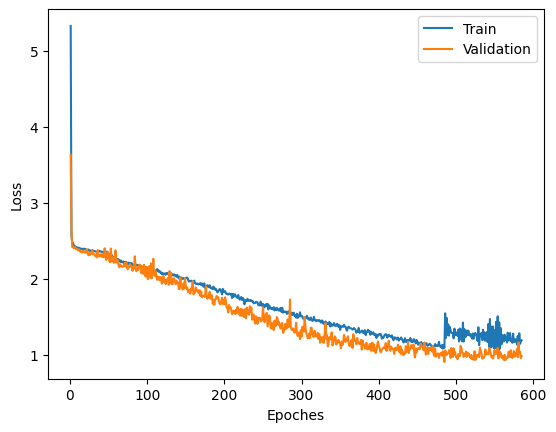

In [13]:
plot_loss(history)


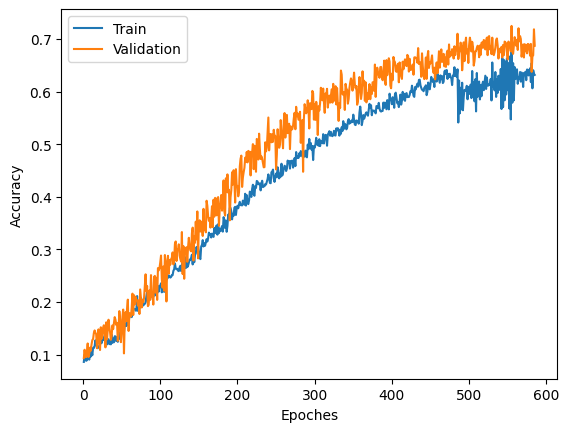

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
